In [12]:
# Import modules
from glob import glob
import numpy as np
from os import makedirs
from math import log10
from pandas import DataFrame
# from matplotlib import rc, rcParams
import matplotlib.pyplot as plt
from impedance import preprocessing
from galvani.BioLogic import MPRfile
from impedance.models.circuits import CustomCircuit, Randles
from impedance.visualization import plot_nyquist, plot_bode, plot_residuals

In [13]:
freq_limits = [1e-4, 1e6]
ignore_below_X = True
add_decade_freq_points = True
decade_threshold = 0.08

In [14]:
# Convert data from mpr file into csv
filenames = glob('*.mpr')
print('Found {} files.'.format(len(filenames)))
for filename in filenames:
    print(filename)
filename = filenames[0]
print('\nUsing file: {}'.format(filename))

data = DataFrame(MPRfile(filename).data)
freq = data['freq/Hz']
real_Z = data['Re(Z)/Ohm']
imag_Z = -1*data['-Im(Z)/Ohm']
np.savetxt('data.csv', np.column_stack((freq, real_Z, imag_Z)), delimiter=',')

Found 1 files.
220224-PanasonicBR2032-100SoC-PEIS_C03.mpr

Using file: 220224-PanasonicBR2032-100SoC-PEIS_C03.mpr


In [15]:
# Read from csv file and pre-process
frequencies, Z = preprocessing.readCSV('data.csv')
if ignore_below_X:
    frequencies, Z = preprocessing.ignoreBelowX(frequencies, Z)
mask = frequencies <= freq_limits[1]
frequencies, Z = frequencies[mask], Z[mask]
mask = frequencies >= freq_limits[0]
frequencies, Z = frequencies[mask], Z[mask]


if add_decade_freq_points:
    # Figure out those frequencies close to a decade and save to separate array
    decade_indices = []
    for i in range(len(frequencies)):
        if abs(log10(frequencies[i]) - round(log10(frequencies[i]))) < decade_threshold:
            decade_indices.append(i)

    frequencies_d = frequencies[decade_indices]
    print('Frequencies: ', frequencies_d )
    app = lambda y: [np.round(log10(i)) for i in frequencies_d]
    print('Rounded logarithmic Frequencies: ', app(frequencies_d))


Frequencies:  [9.45386719e+04 8.93478711e+03 8.45270203e+02 1.18371193e+02
 1.11926908e+01 1.05889142e+00 1.00070424e-01]
Rounded logarithmic Frequencies:  [5.0, 4.0, 3.0, 2.0, 1.0, 0.0, -1.0]


In [16]:
# Define circuit with iniital values
title = 'title'

foldername = 'C1'
circuit = CustomCircuit('R0-p(R1,CPE0)-W', initial_guess=[18, 500,0.0001,0.99, 100])

# foldername = 'C2'
# circuit = CustomCircuit('R0-p(R1,CPE0)-T0', initial_guess=[18, 500,0.0001,0.99, 1e2,1e-12,1e-1,5e1])


# Fit to circuit and write outputs
circuit.fit(frequencies, Z, global_opt=False, weight_by_modulus=True)
print(circuit)
makedirs(foldername, exist_ok=True)
circuit.save(foldername+'/circuit.json')
file = open(foldername+'/circuit.txt', 'w')
file.write(str(circuit))
file.close()


# Compute residuals
res_real = (Z - circuit.predict(frequencies)).real/np.abs(Z)
res_imag = (Z - circuit.predict(frequencies)).imag/np.abs(Z)



Circuit string: R0-p(R1,CPE0)-W
Fit: True

Initial guesses:
     R0 = 1.80e+01 [Ohm]
     R1 = 5.00e+02 [Ohm]
  CPE0_0 = 1.00e-04 [Ohm^-1 sec^a]
  CPE0_1 = 9.90e-01 []
      W = 1.00e+02 [Ohm sec^-1/2]

Fit parameters:
     R0 = 8.52e+00  (+/- 1.03e-01) [Ohm]
     R1 = 5.36e+02  (+/- 8.90e+00) [Ohm]
  CPE0_0 = 3.34e-05  (+/- 1.59e-06) [Ohm^-1 sec^a]
  CPE0_1 = 7.96e-01  (+/- 6.20e-03) []
      W = 3.54e+01  (+/- 9.65e+00) [Ohm sec^-1/2]



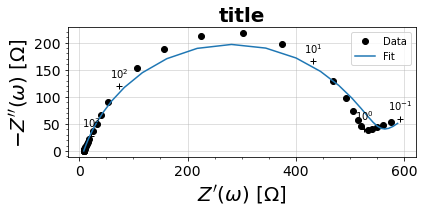

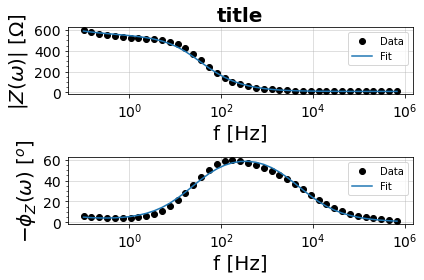

In [28]:
# Plot Nyquist
fig, ax = plt.subplots(tight_layout=True, facecolor='w')

if add_decade_freq_points:
    plot_nyquist(ax, Z[[i for i in range(len(Z)) if i not in decade_indices]],
    fmt='o', units='\Omega', label='Data', color='black')
    plot_nyquist(ax, Z[decade_indices], fmt='+', color='black')
    # Add frequency labels for decades
    for i in decade_indices[2:]:
        string = r'$10^{exponent}$'.format( 
            exponent= '{'+str(int(np.round(log10(frequencies[i]))))+'}' )
        # print(string)
        ax.text(Z[i].real, -Z[i].imag+25, string,
                horizontalalignment='center', verticalalignment='center')
else:
    plot_nyquist(ax, Z, fmt='o', units='\Omega', label='Data', color='black')

# Plot fit data
plot_nyquist(ax, circuit.predict(frequencies), fmt='-', units='\Omega', label='Fit')
plt.minorticks_on()
plt.legend()
plt.title(title, fontsize=20, fontweight='bold')
fig1 = plt.gcf()
fig1.savefig(foldername+'/nyquist.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()


# Plot Bode
fig, ax = plt.subplots(2, 1, tight_layout=True, facecolor='w')
plot_bode(ax, frequencies, Z, fmt='o', units='\Omega', label='Data', color='black')
plot_bode(ax, frequencies, circuit.predict(frequencies), fmt='-', units='\Omega', label='Fit')
# plt.minorticks_on()
ax[0].minorticks_on()
ax[1].minorticks_on()
ax[0].set_title(title, fontsize=20, fontweight='bold')
ax[0].legend()
ax[1].legend()
plt.savefig(foldername+'/bode.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

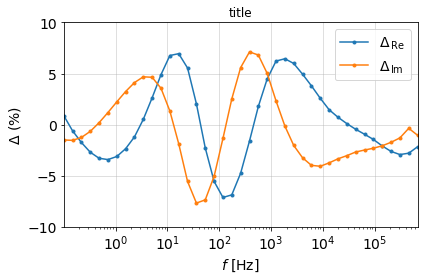

In [18]:
# Plot residuals
fig, ax = plt.subplots(tight_layout=True, facecolor='w')
plot_residuals(ax, frequencies, res_real, res_imag, y_limits=(-10,10))
plt.title(title)
plt.savefig(foldername+'/residuals.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()